In [1]:
from utils import (
    get_som_labeled_img,
    check_ocr_box,
    get_caption_model_processor,
    get_yolo_model,
)
import torch
from ultralytics import YOLO
from PIL import Image

device = "mps" if torch.backends.mps.is_available() else "cpu"
model_path = "weights/icon_detect_v1_5/model_v1_5.pt"

som_model = get_yolo_model(model_path)

som_model.to(device, dtype=torch.bfloat16)
print("model to {}".format(device))

model to mps


In [2]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
import utils

importlib.reload(utils)
from utils import (
    get_som_labeled_img,
    check_ocr_box,
    get_caption_model_processor,
    get_yolo_model,
)

# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(
    model_name="florence2",
    model_name_or_path="weights/icon_caption_florence",
    device=device,
)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
som_model.device, type(som_model)

(device(type='mps', index=0), ultralytics.models.yolo.model.YOLO)

In [8]:
# reload utils
import importlib
import utils

importlib.reload(utils)
from utils import (
    get_som_labeled_img,
    check_ocr_box,
    get_caption_model_processor,
    get_yolo_model,
)

# Clear cache / memory
import torch
torch.mps.empty_cache()

image_path = "imgs/google_page.png"
image_path = "imgs/windows_home.png"
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = "imgs/word.png"
# image_path = 'imgs/excel2.png'

image = Image.open(image_path)
image_rgb = image.convert("RGB")
print("image size:", image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    "text_scale": 0.8 * box_overlay_ratio,
    "text_thickness": max(int(2 * box_overlay_ratio), 1),
    "text_padding": max(int(3 * box_overlay_ratio), 1),
    "thickness": max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time

start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(
    image_path,
    display_img=False,
    output_bb_format="xyxy",
    goal_filtering=None,
    easyocr_args={"paragraph": False, "text_threshold": 0.8},
    use_paddleocr=True,
)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time()

batch_size = 4 # to reduce memory

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(
    image_path,
    som_model,
    BOX_TRESHOLD=BOX_TRESHOLD,
    output_coord_in_ratio=True,
    ocr_bbox=ocr_bbox,
    draw_bbox_config=draw_bbox_config,
    caption_model_processor=caption_model_processor,
    ocr_text=text,
    use_local_semantics=True,
    iou_threshold=0.7,
    scale_img=False,
    batch_size=batch_size,
)
cur_time_caption = time.time()

image size: (1919, 1079)

image 1/1 /Users/macbookair/Workspace/OmniParser/OmniParserClone/imgs/word.png: 736x1280 115 icons, 547.8ms
Speed: 368.1ms preprocess, 547.8ms inference, 40.2ms postprocess per image at shape (1, 3, 736, 1280)


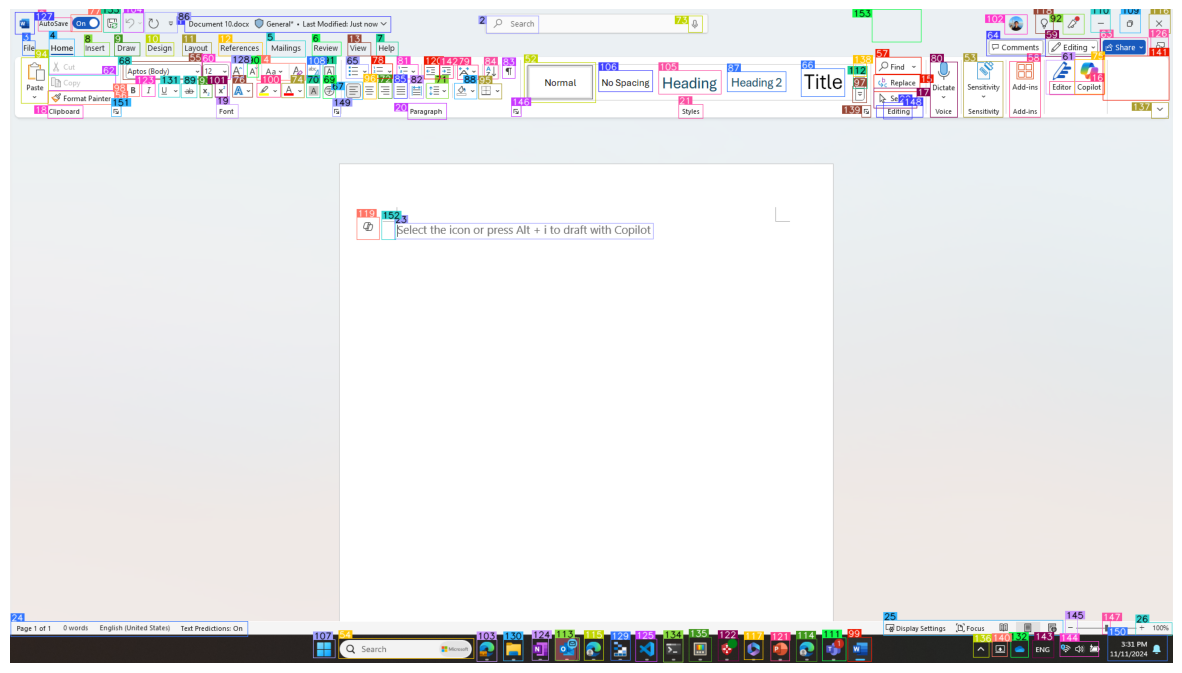

In [9]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [10]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,ID
0,text,"[0.023970818147063255, 0.012974976561963558, 0...",False,AutoSave,0
1,text,"[0.1500781625509262, 0.011121409013867378, 0.3...",False,Document 10.docx General* Last Modified: Jus...,1
2,text,"[0.4095883369445801, 0.011121409013867378, 0.4...",False,O Search,2
3,text,"[0.010943199507892132, 0.048192769289016724, 0...",False,File,3
4,text,"[0.03335070237517357, 0.045412417501211166, 0....",False,Home,4
...,...,...,...,...,...
149,icon,"[0.27761775255203247, 0.1486130803823471, 0.28...",True,a black line or symbol.,149
150,icon,"[0.9438195824623108, 0.9580724239349365, 0.995...",True,a notification indicating the time as 3:,150
151,icon,"[0.08738607168197632, 0.14846171438694, 0.0954...",True,A black symbol or symbol.,151
152,icon,"[0.3194708228111267, 0.32148948311805725, 0.33...",True,a line or bar.,152
